In [1]:
using JuMP
using Random
using Pkg
Pkg.add("Gurobi")
using Gurobi
using PyPlot




    Updating registry at `C:\Users\bklat\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\bklat\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\bklat\.julia\environments\v1.8\Manifest.toml`




# Traveling Salesman: Optimality vs Heuristics #

#### Addison Latterell (AddLatterell)


*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
  1. [Heurisitc Algorithms](#2.A-Heuristic-Algorithms)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [Optional Subsection](#4.A.-Feel-free-to-add-subsections)
1. [Conclusion](#5.-Conclusion)

Traveling salesperson problems are NP-Complete. Some large problems may take very long to solve optimally. In situations where speed is necessary, there are several heuristics that can reliably find solution approximations that are close to optimal much more quickly. I want to compare the optimization based solutions to the heurisitcs available for varying network sizes and time requirements.

 I will model this as a mixed integer program and try to solve it for multiple different network sizes. As for heuristics, i will use: nearest neighbor, christofides, as well as the improvement method 2-opt.

## 1. Introduction ##

The traveling salesperson problem is one that has been worked on by both mathematicians and theoretical computer scientists throughout the 20th century. In this problem, there are a set of locations, each separated from one another by some distance. To solve the problem, you must find a way to search through the possible paths and find an optimal route. An example of this type of path through a number of nodes can be seen in the image below.
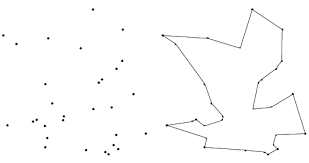

In the 1930s, this problem was first considered mathematically at Princeton, and the first paper using the name "traveling salesperson problem" was [published in 1949](https://apps.dtic.mil/sti/citations/AD0204961). The problem gained notoriety shortly thereafter. This problem is an "NP-Complete" problem, a problem where you can verify the solution easily, but the optimal solution cannot be found in polynomial time. If there are N nodes, (N − 1)! nodes must be checked to be sure of optimality. In 1954, Dantzig, Fulkerson and Johnson [formulated the problem](https://www.rand.org/pubs/papers/P510.html) as an integer linear program and were able to show that using a "subtour elimination constraint" the problem could be solved optimally. In 1960 Miller–Tucker–Zemlin showed an alternate subtour elimination constraint that is slightly weaker but still solves the problem optimally. Both of these are mathematical optimization formulations and as network size increases, solve time increases exponentially, but there are algorithms called heuristics that can arrive at an approximation more quickly. 

As for heuristics, this project will explore three options. The first two will be constructive Heuristics, that is, they construct a tour through the nodes. The first is the [nearest neighbor heuristic](https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm) which, as it's name suggests, selects the nearest next node to travel to on its tour through the network. This is far from an optimal algorithm, as it typically is forced into a corner of the network and then must make a very expensive move to return to the source. The second algorithm [cheapest insertion](https://www-proquest-com.ezproxy.library.wisc.edu/docview/918487894?pq-origsite=gscholar&fromopenview=true), it has an upper bound of 2 times greater than optimal and can still be done quite quickly. Finally, the third heuristic is an improvement algorithm, meaning, it takes a constructed tour and iterates through it to make improvements. In this report, I will be using the [2-opt heuristic](https://en.wikipedia.org/wiki/2-opt) which iterates through the tour, removes two paths, and looks to see if it can substitute more economical paths.


In this report will how compare close the heuristics, alone and in combination with eachother, can get to the optimal solution. As network size increases, I will also compare speed.


## 2. Mathematical optimizaiton models ##


To begin, I will breakdown the strucutre of each of the IP formulations. From now on, Dantzig, Fulkerson and Johnson formulation will be referred to as DFJ and Miller–Tucker–Zemlin will be referred to as MTZ.  Both of these formulations use a binary variable xij that indicates whether or not the arc from node i to node j is part of the tour. 

Belowm the MTZ formulation of the traveling salesperson problem can be seen:

\begin{align*}
\text{minimize} \quad & \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} x_{ij} \\
\text{subject to} \quad & \sum_{j=1, j\neq i}^{n} x_{ij} = 1 \quad && \forall i \in {1,\dots,n} \quad \text{(each city is visited once)} \\
& \sum_{i=1, i\neq j}^{n} x_{ij} = 1 \quad && \forall j \in {1,\dots,n} \quad \text{(each city is left once)} \\
& u_i - u_j + nx_{ij} \leq n-1 \quad && \forall i,j \in {2,\dots,n}, i\neq j \quad \text{(subtour elimination constraint)} \\
& 1 \leq u_i \leq n-1 \quad && \forall i \in {2,\dots,n} \quad \text{(index bounds on u)}   \\
& x_{ij} \in {0,1} \quad && \forall i,j \in {1,\dots,n}, i\neq j \quad \text{(binary constraint)}
\end{align*}

In the objective, this formulation is trying to minimize the cost to create a tour through the netwok. Then, the following two constraints require that a tour can only enter a city once and can only leave a city once. Were only these constraints included, the algorithm would select disconected parts of the network. We need a constraint that ensures all points are visited in one tour. This is called a "subtour-eliminations constraint, and is the purpose of the 3rd constraint. Here, U is an intermediate variable that increases by 1 when it passes through a node other than the origin. When it passes through, the origin, it decreases by one, so the only way to satisfy the constraint is to have the tour visit every node and pass through the origin. 


Below, the DFJ formulation can be seen


\begin{align*}
\text{minimize} \quad & \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} x_{ij} \\
\text{subject to} \quad & \sum_{j=1, j\neq i}^{n} x_{ij} = 1 \quad && \forall i \in {1,\dots,n} \quad \text{(each city is visited once)} \\
& \sum_{i=1, i\neq j}^{n} x_{ij} = 1 \quad && \forall j \in {1,\dots,n} \quad \text{(each city is left once)} \\
& \sum_{ i \in Q} \sum_{i \neq j , j \in Q} x_{ij} \leq |Q| -1 \quad && \text{for all } Q \subset V, 2 \leq |Q| \leq n - 1  \quad \text{(subtour elimination constraint)} \\
\end{align*}

The objective function and the first two constraints of the DFJ formulation are the same as the MTZ formulation. The difference comes in the subtour elimination constraint. Here, Q is a set of nodes in a subtour that could exist. The constraint ensures that no subtour can form, because the number of times the verticies in Q can be entered by xij are 1 less than the value of verticies.  This is a very strong formulation, but creates a very large number of constraints than MTZ: 2^n.




# 2.A Heuristic Algorithms

Here I will cover how each heuristic works and how close it gets to the optimal solution. I will begin by discussing the constructieve herusitics "Nearest Neighbor" and "Christofides Algorithm".

The Nearest Neighbor algorithm is one of the oldest simplest approaches to solving this problem. The steps are as follows.
1. Initialize all vertices as unvisited.
2. Select an arbitrary vertex and set it as the current vertex u. Mark u as visited.
3. For each unvisited vertex v adjacent to the current vertex u, calculate the distance from u to v.
4. Select the unvisited vertex v with the shortest distance to u and set it as the new current vertex u. Mark v as visited.
5. If there are unvisited vertices, go to step 3. Otherwise, terminate.

Although this is a simple and quick algorithm, it often produces solutions that are far from optimal. For example, the algorithm may identify a short path through a few nodes, but then be forced to make expensive choices to complete the tour.

The [Cheapest insertion heuristic](https://www.researchgate.net/publication/220616869_An_Analysis_of_Several_Heuristics_for_the_Traveling_Salesman_Problem) was introduced in 1974 and has a very useful property that the solution will be no more than 2x optimal. The following steps can be used for implementation. 

1. Start with a sub-graph consisting of node i only.
2. Find node r such that cir is minimal and form sub-tour i-r-i.
3. Find (i, j) in sub-tour and r not, such that cir + crj - cij is minimal. Insert r between i and j.


Finally, the 2-opt algorithm can be used to find more economical routes in an existing tour through a network. It is an improvement algorithm, meaning it requires some already created tour. This algorithm begins with the first node in a tour. The steps for implementation can be seen below. This works for all possible combinations of i and k.

1. take route[1] to route[i-1] and add them in order to new route
2. take route[i] to route[k] and add them in reverse order to new route
3. take route[k+1] to end and add them in order to new_route       
4. return the new route;


In this project, we will use both the tour generated by nearest neighbor aswell as the tour generated by Christofides algorithm.


## 2B : Warmstarting Optimization using Heuristics

Finally, I will explore using the output from a heuristic function to warmstart the DFJ optimization formulation. Warmstarting means that I will be providing the solver with an initial feasible solution that it can improve on. Hopefully, this will reduce compute time while providing a solution that is closer to optimal than heuristics alone. The formulation for the DFJ will be the same. The only difference is that I will give initial values to the solver.

## 3. Solution ##

Below, I create a function to generate a symmetrical network. This will allow me to generate new network sizes any time I please.

In [2]:
Random.seed!(920)
function generate_network(n) #this generates a symmetric network 
    matrix = zeros(n, n)

    for i in 1:n
        for j in i:n
            value = rand() * 100
            matrix[i, j] = value

            if i != j
                matrix[j, i] = value
            end
            if i ==j
                matrix[j,i] = 0
            end
        end
    end

    return matrix
end

testNet = generate_network(5)

5×5 Matrix{Float64}:
  0.0     41.4835   59.7725  82.5733  86.6977
 41.4835   0.0      63.6714  40.8437   2.09887
 59.7725  63.6714    0.0     78.7968  60.6063
 82.5733  40.8437   78.7968   0.0     68.439
 86.6977   2.09887  60.6063  68.439    0.0

# MTZ Formulation 

 Below, I will implement the MTZ formulaiton of the traveling sales person problem. Below are two helper functions to obtain subtours that exist in a solution.

In [3]:
#helper functions to create constraints for subtour elimination
function getSubtour(x,start, numNodes)
    subtour = [start]
    while true
        j = subtour[end]
        for k in 1:numNodes
            if x[k,j] == 1
                push!(subtour,k)
                break
            end
        end
        if subtour[end] == start
            break
        end
    end
    return subtour
end


function getAllSubtours(x, numNodes)
    nodesRemaining = 1:numNodes
    subtours = []
    while length(nodesRemaining) > 0
        subtour = getSubtour(x,nodesRemaining[1], numNodes)
        push!(subtours, subtour)
        nodesRemaining = setdiff(nodesRemaining,subtour)
    end
    return subtours
end
;

Here is the actual implementation. 

In [4]:

function MTZ(distMat)
    N = size(distMat,1); #number of nodes
    m = Model(Gurobi.Optimizer)

    #Below i formulate the program with the MTZ Constraints
    @variable(m, x[1:N,1:N], Bin) # 1 if it takes this path, 0 otherwise

    @constraint(m, inConst[j in 1:N], sum( x[i,j] for i in 1:N ) == 1) #one way in
    @constraint(m, outConst[i in 1:N], sum( x[i,j] for j in 1:N ) == 1) #one way out
    @constraint(m, selfConst[i in 1:N], x[i,i] == 0 )  #cant loop to self

    # Constraints to deal with subtour elimination
    @variable(m, u[1:N])

    @constraint(m, subtourElim[i in 1:N, j in 2:N], u[i] - u[j] + N*x[i,j] <= N-1 ) #MTZ subtour elimination

    @objective(m, Min, sum(sum( x[i,j]*distMat[i,j] for i in 1:N) for j in 1:N ))   # minimize total cost

    set_silent(m)
    optimize!(m)
    objective_value(m)

     xx = value.(x)
     subtours = getAllSubtours(xx, N)
     return subtours, objective_value(m)
    #println("Tour length: ", objective_value(m))
end


MTZ(testNet)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30


(Any[[1, 3, 5, 2, 4, 1]], 245.89459562076928)

# DFJ Formulation

Below, I will implement the DFJ Formulation of the traveling salesperson problemm. In this implementation, I run the solver adding additional subtour eliminatin constraints until the difference between the best solution and the current solution is minimal.

In [5]:
function DFJ(distMat)#, time_limit=60.0)
    N = size(distMat,1)

    m2 = Model(Gurobi.Optimizer)
    set_silent(m2)

    @variable(m2, x[1:N,1:N], Bin)
    @constraint(m2, c1[j in 1:N], sum( x[i,j] for i in 1:N ) == 1) #basic flow constraints
    @constraint(m2, c2[i in 1:N], sum( x[i,j] for j in 1:N ) == 1)
    @constraint(m2, c3[i in 1:N], x[i,i] == 0 )
    @objective(m2, Min, sum( x[i,j]*distMat[i,j] for i in 1:N, j in 1:N ))

    sols = []

    prev_obj_val = Inf
    while true
        optimize!(m2)
        #Rather than just running through this constraint 30 times, I chose to let it run intil the changes in the objective value are minimal
    
        curr_obj_val = objective_value(m2)
        if abs(curr_obj_val - prev_obj_val) < 1e-5
            break
        end
        prev_obj_val = curr_obj_val
        xx = value.(x)
        push!(sols, xx)
        subtours = getAllSubtours(xx, N)
        len = length(subtours)
        if len == 1
            println("SOLVED!")
            return subtours, objective_value(m2)
            break
        else
            for subtour in subtours
                L = length(subtour)
                @constraint(m2, sum( x[subtour[k+1],subtour[k]] for k = 1:L-1 ) <= L-2) #add DFJ constraints
                @constraint(m2, sum( x[subtour[k],subtour[k+1]] for k = 1:L-1 ) <= L-2)
            end
        end


    end
end


;
DFJ(testNet)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!


(Any[[1, 4, 2, 5, 3, 1]], 245.89459562076928)

# Nearest Neighbor Algorithm

Below I will implement the Nearest Neighbor Construction Heuristic. This heuristic has no gaurentee on the upper bound of the length of the tour created.

In [6]:


using LinearAlgebra

function nearest_neighbor(matrix::Matrix)
    n = size(matrix, 1)
    visited_columns = Bool[] #to keep track of visited columns, true if visited, false otherwise
    for _ in 1:n
        push!(visited_columns, false) #all false
    end

    current_column = 1 #start at one
    visited_columns[current_column] = true #set 1 in boolean mapping to be true
    visit_order = [current_column] #start visit order at 1
    total = 0

    for _ in 1:n-1 #loops for the next n-1 times, since we know we are starting at 1
        min_distance = Inf #upper bound
        next_column = Inf #need to create variable

        for i in 1:n #loops through every row
            if !visited_columns[i] #evaluates to true if visited_columns[i] is false
                distance = matrix[current_column, i] #distance from curr to i in all rows
                if distance < min_distance #if distance is less than min update min
                    min_distance = distance
                    next_column = i
                end
            end
        end
        
        total+= matrix[current_column, next_column] #update total
        visited_columns[next_column] = true #update visited to indicate we will visit next column
        push!(visit_order, next_column) #add to visit order
        current_column = next_column #update current_column for next iteration

    end
    
    
    total += matrix[visit_order[end], first(visit_order)] #cost to get from last to end
    append!(visit_order, 1)
    
    return visit_order, total
    

        
end




path1, cost1 = nearest_neighbor(testNet)

#[1, 7, 3, 4, 8, 2, 9, 5, 6, 10, 1]
    

([1, 2, 5, 3, 4, 1], 265.55862410318514)

# Cheapest insertion

Below, I will implement the cheapest insertion construction heuristic. This algorithm has a property: the tour will be no more costly than 2 times optimal. 

In [7]:
function cheapest_insertion(distance_matrix)
    n = size(distance_matrix, 1) # Get the number of nodes 
    
    visited = falses(n) # keep track of visited nodes
    visited[1] = true   

    path = [1, 1] # Initialize the path with the first node

    total_cost = 0 # Initialize the total cost of the path

    # loop through all the nodes except the first one
    for _ in 1:(n - 1)
        min_cost = Inf # set min cost of insertion and locations
        min_insertion_point = -1 
        min_node_to_insert = -1  

        # loop through all nodes starting at 2 (we know 1 is visited)
        for node in 2:n
            if !visited[node] # Check if the node has not been visited
                # Loop through the path except the last node
                for i in 1:(length(path) - 1)
                    # Calculate the insertion cost of the node at position i
                    insertion_cost = distance_matrix[path[i], node] + distance_matrix[node, path[i + 1]] - distance_matrix[path[i], path[i + 1]]

                    # Check if the insertion cost is less than the current minimum cost
                    if insertion_cost < min_cost
                        min_cost = insertion_cost # update min cost
                        min_insertion_point = i + 1 # update the index of the insertion point
                        min_node_to_insert = node  # update the node to be inserted
                    end
                end
            end
        end

        insert!(path, min_insertion_point, min_node_to_insert) #insert at correct point
        visited[min_node_to_insert] = true # Mark the inserted node as visited
        total_cost += min_cost # Update total cost
    end

    return path, total_cost # Return the path and its total cost
end

cheapest_insertion(testNet)

([1, 3, 5, 2, 4, 1], 245.89459562076928)

# 2-opt Algorithm

Below I will formulate the 2-opt improvement heuristic. It takes a tour created by one of the previous heuristics, and changes the order of the paths at every node to look for cheaper paths. This algorithm gaurentees that the tour created will be no worse than the tour provided.

In [8]:
##This function calculates the cost of a path accoring to the distance matrix.
function path_cost_from_distance_matrix(dist_m, path)
    cost = 0
    for i in 1:length(path)-1
        cost += dist_m[path[i], path[i+1]]
    end

    cost += dist_m[path[end], path[1]]

    return cost
end

##Swapping action of the 2-opt algorithm
function two_opt_change(route, first, second)
    new_route = zeros(length(route))
    #these swap the now disconnected arcs
    new_route[1:first] = route[1:first]
    new_route[first+1:second] = reverse(route[first+1:second])
    new_route[second+1:end-1] = route[second+1:end-1]
    
    # Connect the last element back to the first element
    new_route[end] = new_route[1]

    return Int.(new_route)
end

##2-opt algorithm

function two_opt(path, distMatrix)
    new_distance=Inf
    best_distance = path_cost_from_distance_matrix(distMatrix,path) #calculates cost of current path
    present_route=path

        for i in 1:length(path)-2
            
            for j in i+1:length(path)-1
                
                new_route = two_opt_change(present_route,i,j)
                
                new_distance = path_cost_from_distance_matrix(distMatrix,new_route)
                diff=abs(best_distance-new_distance)
                if (new_distance < best_distance) 
                    #println(new_distance)
                    present_route = new_route
                    best_distance = new_distance
                end
            end
        end
        return best_distance, present_route
end


two_opt(path1, testNet)[1]

245.89459562076925

# Warm Start DFJ

Below I will run the DFJ optimization formulation again, but this time I will provide it with a warm start. This means that I will give it a feasible solution provided by the heuristics above and ask it to improve on this solution. I would like to see if this allows DFJ to find a close to optimal solution in less time. If the algorithm takes more than 4 subtour elimination constraints, I will just return the heuristic value. This is to help make sure that it does not run for too long. 

In [9]:
function DFJ_warmstart(distMat, initial_info)
    N = size(distMat,1)
    
    initial_tour = initial_info[2]
    initial_cost = initial_info[1]
    m3 = Model(Gurobi.Optimizer)
    set_silent(m3)

    @variable(m3, x[1:N,1:N], Bin)
    @constraint(m3, c1[j in 1:N], sum( x[i,j] for i in 1:N ) == 1)#basic flow constraints
    @constraint(m3, c2[i in 1:N], sum( x[i,j] for j in 1:N ) == 1)
    @constraint(m3, c3[i in 1:N], x[i,i] == 0 )
    @objective(m3, Min, sum( x[i,j]*distMat[i,j] for i in 1:N, j in 1:N ))

    # Warmstart with the heuristic path
    for (i, j) in zip(initial_tour[1:end-1], initial_tour[2:end])
        set_start_value(x[i, j], 1) #set initial values
    end
    set_start_value(x[initial_tour[end], initial_tour[1]], 1)

    sols = []
    
    for _ in 1:4
        optimize!(m3)
        xx = value.(x)
        push!(sols, xx)
        subtours = getAllSubtours(xx, N)
        len = length(subtours)
        if len == 1
            println("SOLVED!")
            return subtours, objective_value(m3)
            break
        else
            for subtour in subtours
                L = length(subtour)
                @constraint(m3, sum( x[subtour[k+1],subtour[k]] for k = 1:L-1 ) <= L-2) #DFJ constraints
                @constraint(m3, sum( x[subtour[k],subtour[k+1]] for k = 1:L-1 ) <= L-2)
            end
        end
    end
    optimize!(m3)
    xx = value.(x)
    push!(sols, xx)
    subtours = getAllSubtours(xx, N)
    if length(subtours) == 1  #if it returning multiple subtours after a few iterations, return heuristic value
        return subtours, objective_value(m3)
        
    else
        return initial_tour, initial_cost
    end 

end

net = generate_network(100)
DFJ_warmstart(net , two_opt(nearest_neighbor(net)[1], net))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30


([1, 26, 86, 47, 39, 66, 41, 93, 91, 9  …  23, 21, 68, 36, 40, 72, 42, 89, 13, 1], 353.4992244400436)

## 4. Results and discussion ##

Here, you display and discuss the results. Show figures, plots, images, trade-off curves, or whatever else you can think of to best illustrate your results. The discussion should explain what the results mean, and how to interpret them. You should also explain the limitations of your approach/model and how sensitive your results are to the assumptions you made.


Below, I will graph the time it takes for each optimization formulation, as well how close the heuristics are to optimal values. Pay close attention to the scale of the y-axis in all of the graphs. While they are all in seconds, some are a very small decimal while others are integer values.

In [10]:
#this cell is to collect runtime and distance from optimal for the different algorithms and heuristics
NNTime = []
NNCost = []
InsertTime = []
InsertCost = []

NN_2opt = []
NN_2optCost = []
Insert_2opt = []
Insert_2optCost = []

DFJWrmStrtTime = []
DFJWrmStrtCost = []


DFJTime = []
DFJCost = []
MTZTime = []
MTZCost = []


for i in 2:58 #gather information on networks of varying sizes, my computer could not handle anything greater than 58 
    net = generate_network(i)
    
    append!(DFJTime, @elapsed _, opt1 = DFJ(net)  ) #optimization dfj
    append!(MTZTime, @elapsed _, opt2 = MTZ(net)  ) #optimization MTZ
    
    append!(NNTime, @elapsed _, costnn= nearest_neighbor(net)  ) 
    append!(NNCost, costnn - opt1)
    
    append!(InsertTime, @elapsed _, costInsert = cheapest_insertion(net)  )
    append!(InsertCost, costInsert - opt1 )
    
    append!(DFJWrmStrtTime, @elapsed _, wrmstrt = DFJ_warmstart(net , two_opt(nearest_neighbor(net)[1], net)))
    append!(DFJWrmStrtCost, wrmstrt - opt1)
    
    append!(NN_2opt, @elapsed costn2, _ = two_opt(nearest_neighbor(net)[1], net))
    append!(NN_2optCost, costn2-opt1)
    
    append!(Insert_2opt, @elapsed costc2, _ = two_opt(cheapest_insertion(net)[1], net))
    append!(Insert_2optCost, costc2 - opt1)
    
    println(i)
    

    
end
;

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
2
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
3
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
4
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
Set parameter Username
Acade

SOLVED!
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
30
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
31
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
32
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
SOLVED!
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-30
Set parameter Username
Ac

58


In the graph below, I plot the time it took in seconds for each of of the optimization algorithms to complete. Clearly, the MTZ formulation takes much longer to complete than the DFJ. This was very interesting to see. Where DFJ saw small increases in compute time, MTZ spiked much higher

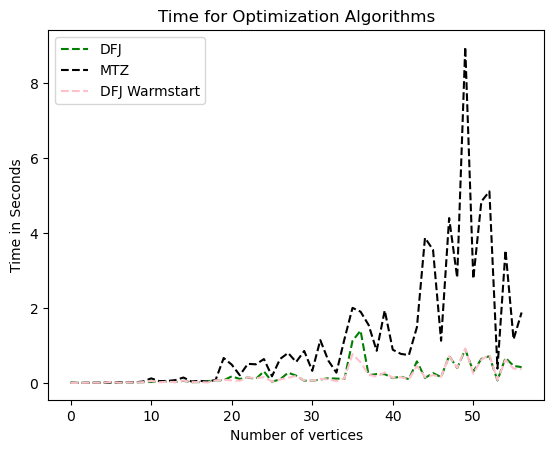

PyObject <matplotlib.legend.Legend object at 0x000002770534C910>

In [11]:
plot(DFJTime, color="green", linestyle="--", label="DFJ") 
plot(MTZTime, color="black", linestyle="--", label="MTZ")
plot(DFJWrmStrtTime, color = "pink", linestyle = "--", label = "DFJ Warmstart")
xlabel("Number of vertices")
ylabel("Time in Seconds")
title("Time for Optimization Algorithms")
legend()

In the graph below, the compute times for the two construction heuristics, Nearest Neighbor and Cheapest Insertion can be seen. Time to complete cheapest insertion increases much faster than nearest neighbor does. They tend to spike at the same time, although Nearest Neighbor sees much smaller spikes.

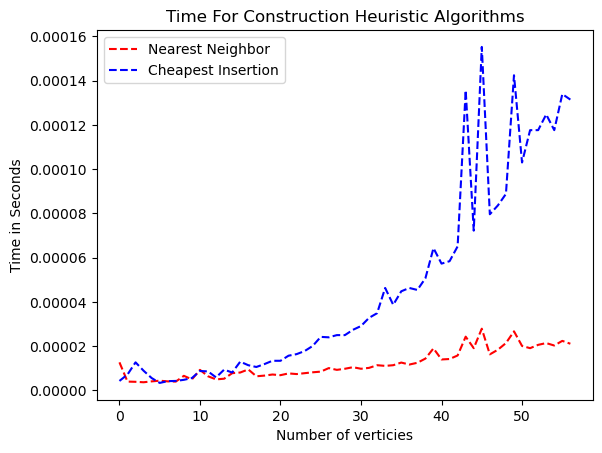

PyObject <matplotlib.legend.Legend object at 0x0000027705BAED00>

In [12]:

plot(NNTime, color="red", linestyle="--", label = "Nearest Neighbor")
plot(InsertTime, color="blue", linestyle = "--", label = "Cheapest Insertion")
xlabel("Number of verticies")
ylabel("Time in Seconds")
title("Time For Construction Heuristic Algorithms")
legend()


Below, the compute times can be seen for each of the 2-opt algorithms. They tend to increase very similarily with eachother which is very interesting. Because the both the Nearest Neighbor and Cheapest Insertion take less than a 100 thousandth of a second to complete, the difference between the two is minimal. 2-opt seems to take the exact same compute time for each algorithm, so obtaining a good origninal tour is very important. 

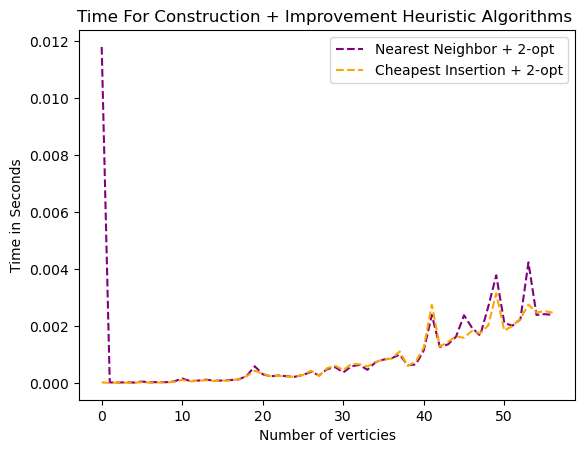

PyObject <matplotlib.legend.Legend object at 0x00000277053F7430>

In [13]:
plot(NN_2opt, color="purple", linestyle="--", label ="Nearest Neighbor + 2-opt")
plot(Insert_2opt, color="orange", linestyle = "--", label = "Cheapest Insertion + 2-opt")
xlabel("Number of verticies")
ylabel("Time in Seconds")
title("Time For Construction + Improvement Heuristic Algorithms ")
legend()

Below, the distance from optimal can be seen for each heuristic. It is very interesting to see that although Cheapest Insertion has a theoretical upperbound on the value of the tour it creates, Nearest Neighbor often creates cheaper tours. The 2-opt algorithm consistantly improves on the tour it is given which is good to see. We could choose the minimum between the NN-2-opt and the CI-2-opt to get the best possible heuristic value. Finally, the DFJ warmstart does not seem to be doing super well. I am not sure that adding a warmstart helped the algorithm in terms of time complexity much at all. However, it does allow us to try for an optimal solution, and if that fails just return the heuristic solution. 

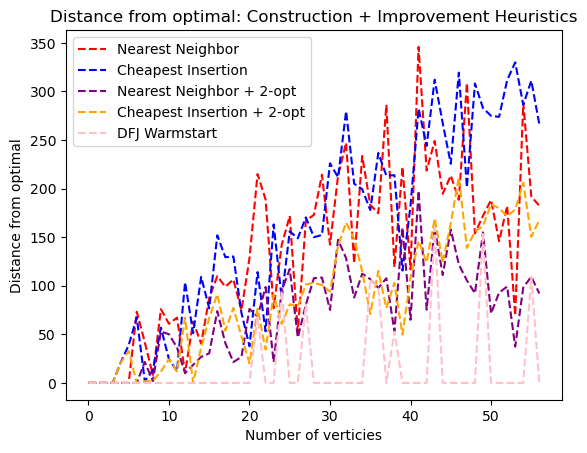

PyObject <matplotlib.legend.Legend object at 0x0000027705425CA0>

In [14]:
plot(NNCost, color="red", linestyle="--", label = "Nearest Neighbor")
plot(InsertCost, color="blue", linestyle = "--", label = "Cheapest Insertion")

plot(NN_2optCost, color="purple", linestyle="--", label = "Nearest Neighbor + 2-opt")
plot(Insert_2optCost, color="orange", linestyle = "--", label = "Cheapest Insertion + 2-opt")

plot(DFJWrmStrtCost, color = "pink", linestyle = "--", label = "DFJ Warmstart")

xlabel("Number of verticies")
ylabel("Distance from optimal")
title("Distance from optimal: Construction + Improvement Heuristics")
legend()

## 5. Conclusion ##


I found that, as expected, the optimization algorithms do best when the network size is reasonably small but will always reach the optimal tour. In contrast, the heuristics power through large networksizes without difficulty, but their distance from optimal tends to increase as nework size increases. Warmstarting the DFJ did not seem to make a big difference. Generally, it took the same the same amount of time to reach optimal as the non warmstarted DFJ, and much of the time when the warmstarted DFJ terminates before the regular DFJ, it defaults to return the heuristic value. One of the frustrating parts of this verification process, was that I found my computer was unable to handle network sizes over 65 which put a cap on the analysis I could do. 


I would love to implement the Christofides algorithm and apply 2opt to its tour. One of the requirements for the Christofides algorithm is a minimum cost perfect matching, which can be solved by the blossomV algorithm which is quite complicated. The only Julia package that can implement BlossomV requires the installation of a C++ compiler, which started to get out of the scope. 

I also would like to explore the warmstart of the optimization algorithm more, to see if that really generates a benefit at all. For large scale problems. It is difficult to see how these algorithms do as number of nodes approaches 100 because it is difficult to find those answers in a reasonable amount of time. 
